# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [3]:
# для дальнейшего использования GridSearchCV
from sklearn.base import BaseEstimator

class GradientBoosting(BaseEstimator):
    def __init__(self, n_estimators=50, max_depth=3, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gammas = np.array([])
        self.trees = np.array([])
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        y_new = y
        for i in range(self.n_estimators):
            y_new = y_new - self._fit_predict_tree(x, y_new)

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
        tree = tree.fit(x, y)
        # находим гамму
        gamma = self._find_optimal_gamma(tree, x, y)
        # запоминаем результаты
        self.gammas = np.append(self.gammas, gamma)
        self.trees = np.append(self.trees, tree)
        # возвращаем предикшн
        return gamma * self.learning_rate * tree.predict(x)
    
    # для нахождения оптимального гамма значения видимо подразумевалось
    # написание собственной функции    
    def _find_optimal_gamma(self, tree, x, y):
        init_gamma = 0.5
        
        loss = lambda g: np.sum((g * tree.predict(x) - y)**2) / x.shape[0]
        result = minimize(loss, init_gamma, method='Powell')
        return result.x
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = sum(self.learning_rate * self.gammas[i] * self.trees[i].predict(x)
                        for i in range(self.trees.size))
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [4]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

__Базовый результат модели:__

In [6]:
gb = GradientBoosting()
gb.fit(X_train, y_train)

mean_squared_error(y_test, gb.predict(X_test))

12.455427194837087

Данный результат не превзошел границу 9.6319. Можно попробовать использовать GridSearch для подбора оптимальных гиперпараметров

In [7]:
from sklearn.model_selection import GridSearchCV

np.random.seed(19052019)

grid = {
    'n_estimators': [75, 100, 125, 150],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.25, 0.5]
}

gs = GridSearchCV(estimator=GradientBoosting(), param_grid=grid, 
                  scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

mean_squared_error(y_test, gs.predict(X_test))

12.450365469019825

In [8]:
gs.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 125}

Попробуем использовать читерский способ для получения необходимого качества

In [9]:
mse_best = 12.450365469019825

for ests in np.arange(10, 150, 5):
    gb = GradientBoosting(n_estimators=ests, max_depth=3, learning_rate=0.1)
    gb.fit(X_train, y_train)
    score = mean_squared_error(y_test, gb.predict(X_test))
    if score < mse_best:
        print(f'Optimal n_estimators: {ests}\nScore: {score}')
        print()

Optimal n_estimators: 40
Score: 12.3716835344402

Optimal n_estimators: 115
Score: 12.441551707979079

Optimal n_estimators: 120
Score: 12.404961535011662



In [10]:
# Зафиксируем n_estimators и попробуем увеличить качество


for depth in [3, 4, 5, 6, 7, 8, 9, 10, 11]:
    gb = GradientBoosting(n_estimators=40, max_depth=depth, learning_rate=0.1)
    gb.fit(X_train, y_train)
    score = mean_squared_error(y_test, gb.predict(X_test))
    if score < mse_best:
        print(f'Optimal depth: {depth}\nScore: {score}')
        print()

Optimal depth: 3
Score: 12.3716835344402

Optimal depth: 5
Score: 11.323630071240538

Optimal depth: 6
Score: 11.018960036590952

Optimal depth: 7
Score: 11.003075409001728

Optimal depth: 8
Score: 10.90048848730097

Optimal depth: 9
Score: 12.10459726703617

Optimal depth: 10
Score: 12.32368385857071



In [11]:
# Теперь, зафиксировав depth = 7, подберем lr
mse_best = 10.90048848730097

for lr in np.arange(0, 1, 0.03):
    gb = GradientBoosting(n_estimators=40, max_depth=8, learning_rate=lr)
    gb.fit(X_train, y_train)
    score = mean_squared_error(y_test, gb.predict(X_test))
    if score < mse_best:
        print(f'Optimal lr: {lr}\nScore: {score}')
        print()

Optimal lr: 0.12
Score: 10.302737672543273

Optimal lr: 0.15
Score: 10.096327308362635

Optimal lr: 0.18
Score: 10.576558869844584

Optimal lr: 0.21
Score: 10.45882697229527

Optimal lr: 0.24
Score: 10.569693080352302

Optimal lr: 0.3
Score: 10.223782166561449

Optimal lr: 0.32999999999999996
Score: 10.787493755188505

Optimal lr: 0.36
Score: 9.584452557547406

Optimal lr: 0.39
Score: 10.163553578414849

Optimal lr: 0.42
Score: 10.435460018565347

Optimal lr: 0.51
Score: 9.775995089179395

Optimal lr: 0.54
Score: 10.535055764508487

Optimal lr: 0.6
Score: 10.316641468701405

Optimal lr: 0.6599999999999999
Score: 10.123537232738462

Optimal lr: 0.75
Score: 10.865433712644231

Optimal lr: 0.8099999999999999
Score: 10.338328523637976



Получилось достигнуть лучшего качества, чем на RandomForest, однако возможно мы подогнались под тест, что не говорит в пользу модели

Итоговая модель:

In [12]:
gb = GradientBoosting(n_estimators=40, max_depth=8, learning_rate=0.36)
gb.fit(X_train, y_train)
score = mean_squared_error(y_test, gb.predict(X_test))
print(score)

9.584452557547406


Это качество чуть лучше, чем 9.63 от RandomForest

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [13]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [14]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [15]:
# Референс
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb = XGBClassifier()
xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

C:\Users\dima1\Anaconda3\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\dima1\Anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\dima1\Anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\dima1\Anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.UInt64Index is deprecated and will be remove

0.7043397869416514

Воспользуемся библиотекой Catboost для получения необходимого нам качества. В данных много категориальных признаков, а Catboost как раз для этого предназначен :)

In [16]:
categorical_features = train.drop('dep_delayed_15min', axis=1).select_dtypes('object').columns.values
categorical_features

array(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin',
       'Dest'], dtype=object)

In [17]:
from catboost import CatBoostClassifier

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(train.drop('dep_delayed_15min', axis=1), 
                                                                    train['dep_delayed_15min'],
                                                                    random_state=42)

catboost = CatBoostClassifier(cat_features=categorical_features,
                              eval_metric='AUC', random_state=42)
catboost.fit(X_train_cat, y_train_cat)

roc_auc_score(y_test_cat, catboost.predict_proba(X_test_cat)[:, 1])

Learning rate set to 0.065101
0:	total: 222ms	remaining: 3m 41s
1:	total: 277ms	remaining: 2m 18s
2:	total: 335ms	remaining: 1m 51s
3:	total: 369ms	remaining: 1m 31s
4:	total: 407ms	remaining: 1m 20s
5:	total: 471ms	remaining: 1m 18s
6:	total: 528ms	remaining: 1m 14s
7:	total: 559ms	remaining: 1m 9s
8:	total: 629ms	remaining: 1m 9s
9:	total: 703ms	remaining: 1m 9s
10:	total: 718ms	remaining: 1m 4s
11:	total: 774ms	remaining: 1m 3s
12:	total: 834ms	remaining: 1m 3s
13:	total: 900ms	remaining: 1m 3s
14:	total: 963ms	remaining: 1m 3s
15:	total: 1.02s	remaining: 1m 3s
16:	total: 1.11s	remaining: 1m 4s
17:	total: 1.18s	remaining: 1m 4s
18:	total: 1.21s	remaining: 1m 2s
19:	total: 1.33s	remaining: 1m 5s
20:	total: 1.35s	remaining: 1m 3s
21:	total: 1.46s	remaining: 1m 4s
22:	total: 1.54s	remaining: 1m 5s
23:	total: 1.61s	remaining: 1m 5s
24:	total: 1.7s	remaining: 1m 6s
25:	total: 1.76s	remaining: 1m 6s
26:	total: 1.83s	remaining: 1m 6s
27:	total: 1.89s	remaining: 1m 5s
28:	total: 1.97s	remai

242:	total: 17.4s	remaining: 54.2s
243:	total: 17.5s	remaining: 54.1s
244:	total: 17.5s	remaining: 54.1s
245:	total: 17.6s	remaining: 54s
246:	total: 17.7s	remaining: 54s
247:	total: 17.8s	remaining: 53.9s
248:	total: 17.8s	remaining: 53.8s
249:	total: 17.9s	remaining: 53.7s
250:	total: 17.9s	remaining: 53.6s
251:	total: 18s	remaining: 53.5s
252:	total: 18.1s	remaining: 53.4s
253:	total: 18.1s	remaining: 53.3s
254:	total: 18.2s	remaining: 53.2s
255:	total: 18.3s	remaining: 53.1s
256:	total: 18.3s	remaining: 53s
257:	total: 18.4s	remaining: 53s
258:	total: 18.5s	remaining: 52.9s
259:	total: 18.6s	remaining: 52.8s
260:	total: 18.6s	remaining: 52.8s
261:	total: 18.7s	remaining: 52.7s
262:	total: 18.8s	remaining: 52.6s
263:	total: 18.8s	remaining: 52.5s
264:	total: 18.9s	remaining: 52.4s
265:	total: 18.9s	remaining: 52.2s
266:	total: 19s	remaining: 52.2s
267:	total: 19.1s	remaining: 52.1s
268:	total: 19.1s	remaining: 52s
269:	total: 19.2s	remaining: 51.9s
270:	total: 19.3s	remaining: 51.9s

480:	total: 34.5s	remaining: 37.2s
481:	total: 34.6s	remaining: 37.2s
482:	total: 34.6s	remaining: 37.1s
483:	total: 34.7s	remaining: 37s
484:	total: 34.8s	remaining: 37s
485:	total: 34.9s	remaining: 36.9s
486:	total: 35s	remaining: 36.8s
487:	total: 35s	remaining: 36.7s
488:	total: 35.1s	remaining: 36.7s
489:	total: 35.2s	remaining: 36.6s
490:	total: 35.3s	remaining: 36.5s
491:	total: 35.3s	remaining: 36.5s
492:	total: 35.4s	remaining: 36.4s
493:	total: 35.5s	remaining: 36.3s
494:	total: 35.5s	remaining: 36.2s
495:	total: 35.6s	remaining: 36.2s
496:	total: 35.7s	remaining: 36.1s
497:	total: 35.7s	remaining: 36s
498:	total: 35.8s	remaining: 36s
499:	total: 35.9s	remaining: 35.9s
500:	total: 36s	remaining: 35.8s
501:	total: 36.1s	remaining: 35.8s
502:	total: 36.1s	remaining: 35.7s
503:	total: 36.2s	remaining: 35.6s
504:	total: 36.3s	remaining: 35.5s
505:	total: 36.3s	remaining: 35.5s
506:	total: 36.4s	remaining: 35.4s
507:	total: 36.5s	remaining: 35.3s
508:	total: 36.6s	remaining: 35.3s

720:	total: 52.2s	remaining: 20.2s
721:	total: 52.2s	remaining: 20.1s
722:	total: 52.3s	remaining: 20s
723:	total: 52.4s	remaining: 20s
724:	total: 52.4s	remaining: 19.9s
725:	total: 52.5s	remaining: 19.8s
726:	total: 52.6s	remaining: 19.7s
727:	total: 52.6s	remaining: 19.7s
728:	total: 52.7s	remaining: 19.6s
729:	total: 52.8s	remaining: 19.5s
730:	total: 52.8s	remaining: 19.4s
731:	total: 52.9s	remaining: 19.4s
732:	total: 53s	remaining: 19.3s
733:	total: 53s	remaining: 19.2s
734:	total: 53.1s	remaining: 19.1s
735:	total: 53.2s	remaining: 19.1s
736:	total: 53.2s	remaining: 19s
737:	total: 53.3s	remaining: 18.9s
738:	total: 53.3s	remaining: 18.8s
739:	total: 53.4s	remaining: 18.8s
740:	total: 53.5s	remaining: 18.7s
741:	total: 53.5s	remaining: 18.6s
742:	total: 53.6s	remaining: 18.5s
743:	total: 53.7s	remaining: 18.5s
744:	total: 53.7s	remaining: 18.4s
745:	total: 53.8s	remaining: 18.3s
746:	total: 53.9s	remaining: 18.3s
747:	total: 54s	remaining: 18.2s
748:	total: 54s	remaining: 18.1s

961:	total: 1m 8s	remaining: 2.71s
962:	total: 1m 8s	remaining: 2.64s
963:	total: 1m 8s	remaining: 2.57s
964:	total: 1m 8s	remaining: 2.5s
965:	total: 1m 8s	remaining: 2.43s
966:	total: 1m 9s	remaining: 2.35s
967:	total: 1m 9s	remaining: 2.28s
968:	total: 1m 9s	remaining: 2.21s
969:	total: 1m 9s	remaining: 2.14s
970:	total: 1m 9s	remaining: 2.07s
971:	total: 1m 9s	remaining: 2s
972:	total: 1m 9s	remaining: 1.93s
973:	total: 1m 9s	remaining: 1.85s
974:	total: 1m 9s	remaining: 1.78s
975:	total: 1m 9s	remaining: 1.71s
976:	total: 1m 9s	remaining: 1.64s
977:	total: 1m 9s	remaining: 1.57s
978:	total: 1m 9s	remaining: 1.5s
979:	total: 1m 9s	remaining: 1.43s
980:	total: 1m 9s	remaining: 1.35s
981:	total: 1m 10s	remaining: 1.28s
982:	total: 1m 10s	remaining: 1.21s
983:	total: 1m 10s	remaining: 1.14s
984:	total: 1m 10s	remaining: 1.07s
985:	total: 1m 10s	remaining: 999ms
986:	total: 1m 10s	remaining: 928ms
987:	total: 1m 10s	remaining: 856ms
988:	total: 1m 10s	remaining: 785ms
989:	total: 1m 10

0.7672089110591024

Получилось достигнуть качества 0.7672, неплохой результат, поставленный порог в 0.74 был пройден

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [18]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import cKDTree

__Важно:__
Так как использовалась библиотека cKDTree, были убраны методы
dist и range_query

In [19]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples

        
    def fit_predict(self, X):
        # создаем K-d дерево (реализованное на плюсах) для наших данных
        point_tree = cKDTree(X) 
        # инициализируем список кластеров
        self.clusters = np.array([-1] * X.shape[0], dtype=int) 
        # создаем матрицу, где на i-ой строки находятся
        self.qb_tree = point_tree.query_ball_tree(point_tree, r=self.eps) 
        # все соседи i-ой точки на расстоянии epsilon
        # далее объявляем кластерный курсор для назначения кластеров объектам
        self.cluster_cursor = 0 
        for i in range(X.shape[0]):
            # если i-ый объект уже кластеризован, то скипаем его
            if self.clusters[i] != -1: 
                continue
            neighbours = np.array(self.qb_tree[i])
            # убираем из числа соседей сам объект
            neighbours = neighbours[neighbours != i] 
            if neighbours.shape[0] >= self.min_samples: 
                # назначем основной точке кластер
                self.clusters[i] = self.cluster_cursor
                 # запускаем процесс кластеризации
                self.grow_cluster(i, neighbours)
                 # как только прокластеризовали точки, связанные с основной, 
                 # переходим к другому кластеру
                self.cluster_cursor += 1
        return self.clusters



    def grow_cluster(self, root, neighbours):
        # всем соседям текущего объекта ставим
        # в соответствие текущий кластерный курсор
        self.clusters[neighbours[self.clusters[neighbours] == -1]] = self.cluster_cursor
        
        # ставим метку о посещении текущего объекта
        self.qb_tree[root] = -1 
        # повторяем тоже самое рекурсивно для соседей текущего объекта
        for neighbour in neighbours: 
            if self.qb_tree[neighbour] != -1 and len(self.qb_tree[neighbour]) >= self.min_samples:
                self.grow_cluster(neighbour, np.array(self.qb_tree[neighbour]))
        

Проверим себя на простом примере:

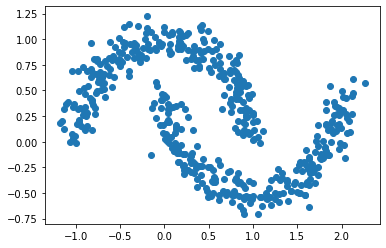

In [20]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

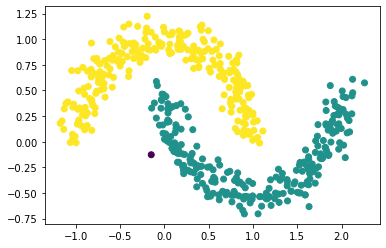

In [21]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

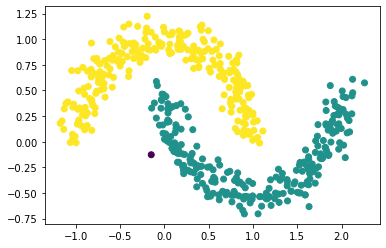

In [22]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



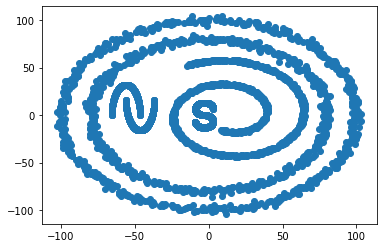

In [23]:
from sklearn.datasets import make_circles, make_s_curve

def make_spiral(n_samples, noise=.5):
    """
     Returns the two spirals dataset.
     
     Код для построение спирали взят отсюда:
     https://glowingpython.blogspot.com/2017/04/solving-two-spirals-problem-with-keras.html
    """
    n = (np.sqrt(np.random.rand(n_samples, 1) + 0.1)) * 800 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_samples, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(n_samples, 1) * noise
    return np.hstack((-d1x, d1y)), np.zeros(n_samples)

circles, _ = make_circles(n_samples=1000, noise=0.02, factor=0.8)
moons, _ = make_moons(n_samples=1000, noise=0.0)
s_curve, _ = make_s_curve(n_samples=1000, noise=0.0)
spiral, _ = make_spiral(n_samples=1000, noise=0.5)

moons_x, moons_y = moons[:, 0] * 1.2 - 7, moons[:, 1] * 4
moons = np.stack((moons_x, moons_y), axis=-1)

curve_x, curve_y = s_curve[:, [0, 2]][:, 0] - 0.5, s_curve[:, [0, 2]][:, 1] * 1.1
curve = np.stack((curve_x, curve_y), axis=-1)

spiral_x, spiral_y = spiral[:, 0] * 0.8 + 3, spiral[:, 1] * 0.8
spiral = np.stack((spiral_x, spiral_y), axis=-1)

X = np.concatenate((circles * 100, moons * 8, curve * 6, spiral * 5))
plt.scatter(X[:,0], X[:,1])
plt.show()

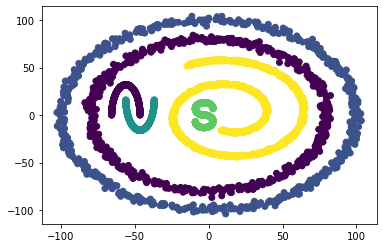

In [24]:
clusters = dbscan(eps=8, min_samples=4).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получилось идеальное разбиение на кластеры

Референс:

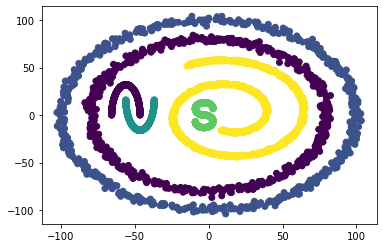

In [25]:
clusters = dbscan(eps=8, min_samples=4).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [26]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 18.9 ms


In [27]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 25 ms


## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

__Запуск DBSCAN:__

In [28]:
from sklearn.cluster import DBSCAN
import seaborn as sns

clusters = DBSCAN().fit_predict(train[['Distance', 'DepTime']])

__Облако рассеивания:__

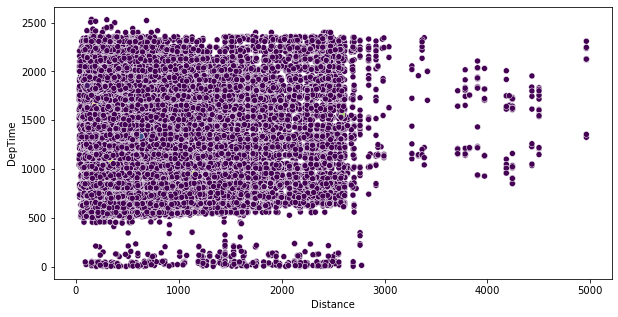

In [29]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=train['Distance'], y=train['DepTime'], c=clusters)
plt.show()

__Ответ:__ Получился 1 большой кластер. В самих данных же находится явно больше 2 кластеров

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ Больше всего шумовых точек получается при большом параметре min_samples, так как на каждую эпсилон окрестность вокруг точки требуется выполнение более строгого условия по наличию минимум большого числа объектов

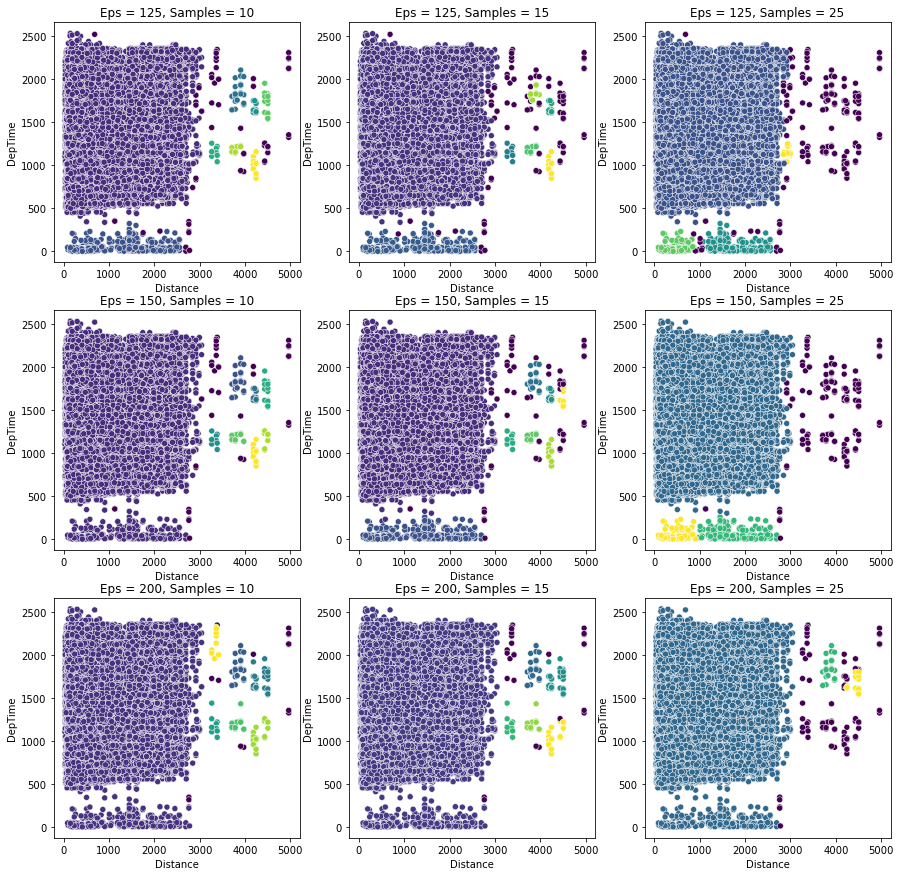

In [30]:
fig, axs = plt.subplots(3, 3)
fig.set_figheight(15)
fig.set_figwidth(15)

axs = axs.flatten()
i = 0
for e in [125, 150, 200]:
    for samples in [10, 15, 25]:
        db = DBSCAN(eps=e, min_samples=samples)
        clusters = db.fit_predict(train[['Distance', 'DepTime']])
        sns.scatterplot(x=train['Distance'], y=train['DepTime'], c=clusters, ax=axs[i])
        axs[i].set_title(f'Eps = {e}, Samples = {samples}') 
        i+=1
plt.show()

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [31]:
train['clusters'] = DBSCAN(eps=125, min_samples=10).fit_predict(train[['Distance', 'DepTime']])

In [32]:
categorical_features = train.drop('dep_delayed_15min', axis=1).select_dtypes('object').columns.values
categorical_features = np.append(categorical_features, np.array(['clusters']))
categorical_features

array(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin',
       'Dest', 'clusters'], dtype=object)

In [33]:
from catboost import CatBoostClassifier

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(train.drop('dep_delayed_15min', axis=1), 
                                                                    train['dep_delayed_15min'],
                                                                    random_state=42)

catboost = CatBoostClassifier(cat_features=categorical_features,
                              eval_metric='AUC', random_state=42)
catboost.fit(X_train_cat, y_train_cat)

roc_auc_score(y_test_cat, catboost.predict_proba(X_test_cat)[:, 1])

Learning rate set to 0.065101
0:	total: 65.4ms	remaining: 1m 5s
1:	total: 129ms	remaining: 1m 4s
2:	total: 197ms	remaining: 1m 5s
3:	total: 265ms	remaining: 1m 5s
4:	total: 328ms	remaining: 1m 5s
5:	total: 384ms	remaining: 1m 3s
6:	total: 452ms	remaining: 1m 4s
7:	total: 511ms	remaining: 1m 3s
8:	total: 575ms	remaining: 1m 3s
9:	total: 640ms	remaining: 1m 3s
10:	total: 659ms	remaining: 59.2s
11:	total: 725ms	remaining: 59.7s
12:	total: 777ms	remaining: 59s
13:	total: 846ms	remaining: 59.5s
14:	total: 933ms	remaining: 1m 1s
15:	total: 1.04s	remaining: 1m 3s
16:	total: 1.14s	remaining: 1m 5s
17:	total: 1.24s	remaining: 1m 7s
18:	total: 1.32s	remaining: 1m 8s
19:	total: 1.4s	remaining: 1m 8s
20:	total: 1.47s	remaining: 1m 8s
21:	total: 1.55s	remaining: 1m 8s
22:	total: 1.61s	remaining: 1m 8s
23:	total: 1.67s	remaining: 1m 7s
24:	total: 1.74s	remaining: 1m 7s
25:	total: 1.81s	remaining: 1m 7s
26:	total: 1.88s	remaining: 1m 7s
27:	total: 1.96s	remaining: 1m 8s
28:	total: 2.03s	remaining: 1m

240:	total: 17.3s	remaining: 54.3s
241:	total: 17.3s	remaining: 54.3s
242:	total: 17.4s	remaining: 54.3s
243:	total: 17.5s	remaining: 54.2s
244:	total: 17.6s	remaining: 54.2s
245:	total: 17.7s	remaining: 54.1s
246:	total: 17.7s	remaining: 54s
247:	total: 17.8s	remaining: 54s
248:	total: 17.9s	remaining: 53.8s
249:	total: 17.9s	remaining: 53.8s
250:	total: 18s	remaining: 53.7s
251:	total: 18.1s	remaining: 53.6s
252:	total: 18.1s	remaining: 53.5s
253:	total: 18.2s	remaining: 53.4s
254:	total: 18.3s	remaining: 53.4s
255:	total: 18.3s	remaining: 53.3s
256:	total: 18.4s	remaining: 53.3s
257:	total: 18.5s	remaining: 53.1s
258:	total: 18.6s	remaining: 53.1s
259:	total: 18.6s	remaining: 53s
260:	total: 18.7s	remaining: 53s
261:	total: 18.8s	remaining: 52.9s
262:	total: 18.8s	remaining: 52.8s
263:	total: 18.9s	remaining: 52.7s
264:	total: 19s	remaining: 52.7s
265:	total: 19.1s	remaining: 52.6s
266:	total: 19.1s	remaining: 52.5s
267:	total: 19.2s	remaining: 52.4s
268:	total: 19.3s	remaining: 52.

477:	total: 34.3s	remaining: 37.4s
478:	total: 34.3s	remaining: 37.4s
479:	total: 34.4s	remaining: 37.3s
480:	total: 34.5s	remaining: 37.2s
481:	total: 34.6s	remaining: 37.1s
482:	total: 34.6s	remaining: 37.1s
483:	total: 34.7s	remaining: 37s
484:	total: 34.8s	remaining: 36.9s
485:	total: 34.9s	remaining: 36.9s
486:	total: 34.9s	remaining: 36.8s
487:	total: 35s	remaining: 36.7s
488:	total: 35.1s	remaining: 36.7s
489:	total: 35.2s	remaining: 36.6s
490:	total: 35.2s	remaining: 36.5s
491:	total: 35.3s	remaining: 36.4s
492:	total: 35.4s	remaining: 36.4s
493:	total: 35.4s	remaining: 36.3s
494:	total: 35.5s	remaining: 36.2s
495:	total: 35.6s	remaining: 36.1s
496:	total: 35.6s	remaining: 36.1s
497:	total: 35.7s	remaining: 36s
498:	total: 35.8s	remaining: 35.9s
499:	total: 35.8s	remaining: 35.8s
500:	total: 35.9s	remaining: 35.8s
501:	total: 36s	remaining: 35.7s
502:	total: 36.1s	remaining: 35.7s
503:	total: 36.2s	remaining: 35.6s
504:	total: 36.2s	remaining: 35.5s
505:	total: 36.3s	remaining:

715:	total: 51.6s	remaining: 20.5s
716:	total: 51.7s	remaining: 20.4s
717:	total: 51.8s	remaining: 20.3s
718:	total: 51.9s	remaining: 20.3s
719:	total: 51.9s	remaining: 20.2s
720:	total: 52s	remaining: 20.1s
721:	total: 52.1s	remaining: 20.1s
722:	total: 52.2s	remaining: 20s
723:	total: 52.2s	remaining: 19.9s
724:	total: 52.3s	remaining: 19.8s
725:	total: 52.4s	remaining: 19.8s
726:	total: 52.4s	remaining: 19.7s
727:	total: 52.5s	remaining: 19.6s
728:	total: 52.6s	remaining: 19.6s
729:	total: 52.7s	remaining: 19.5s
730:	total: 52.7s	remaining: 19.4s
731:	total: 52.8s	remaining: 19.3s
732:	total: 52.9s	remaining: 19.3s
733:	total: 52.9s	remaining: 19.2s
734:	total: 53s	remaining: 19.1s
735:	total: 53.1s	remaining: 19s
736:	total: 53.2s	remaining: 19s
737:	total: 53.3s	remaining: 18.9s
738:	total: 53.3s	remaining: 18.8s
739:	total: 53.4s	remaining: 18.8s
740:	total: 53.5s	remaining: 18.7s
741:	total: 53.6s	remaining: 18.6s
742:	total: 53.6s	remaining: 18.6s
743:	total: 53.7s	remaining: 1

952:	total: 1m 9s	remaining: 3.42s
953:	total: 1m 9s	remaining: 3.35s
954:	total: 1m 9s	remaining: 3.27s
955:	total: 1m 9s	remaining: 3.2s
956:	total: 1m 9s	remaining: 3.13s
957:	total: 1m 9s	remaining: 3.05s
958:	total: 1m 9s	remaining: 2.98s
959:	total: 1m 9s	remaining: 2.91s
960:	total: 1m 9s	remaining: 2.83s
961:	total: 1m 9s	remaining: 2.76s
962:	total: 1m 10s	remaining: 2.69s
963:	total: 1m 10s	remaining: 2.62s
964:	total: 1m 10s	remaining: 2.54s
965:	total: 1m 10s	remaining: 2.47s
966:	total: 1m 10s	remaining: 2.4s
967:	total: 1m 10s	remaining: 2.33s
968:	total: 1m 10s	remaining: 2.25s
969:	total: 1m 10s	remaining: 2.18s
970:	total: 1m 10s	remaining: 2.11s
971:	total: 1m 10s	remaining: 2.04s
972:	total: 1m 10s	remaining: 1.96s
973:	total: 1m 10s	remaining: 1.89s
974:	total: 1m 10s	remaining: 1.82s
975:	total: 1m 11s	remaining: 1.75s
976:	total: 1m 11s	remaining: 1.67s
977:	total: 1m 11s	remaining: 1.6s
978:	total: 1m 11s	remaining: 1.53s
979:	total: 1m 11s	remaining: 1.46s
980:	

0.7675735725045808

__Ответ:__ Качество практически не улучшилось. Видимо информация о том, к какому кластеру относится перелет, была каким-то образом добыта катбустом, поэтому разбиение на кластеры не помогло увеличить качество.

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

Студенты в июне не отдыхают, а плачут :(

**+0.1 балла** за смешной мем по машинному обучению

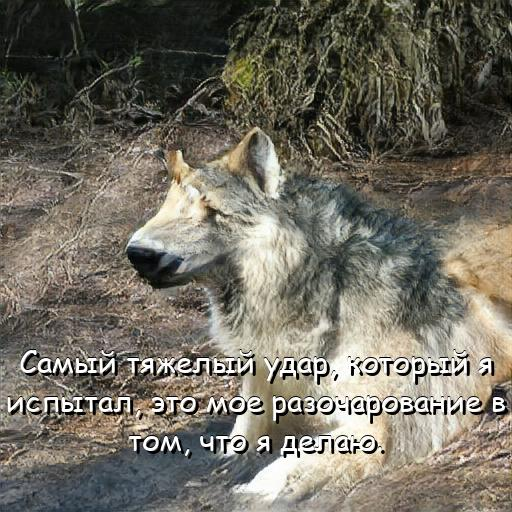

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.

Классный курс, особенно понравилось, как устроены дедлайны. Пару раз право сдать домашку после мягкого делайна без штрафа сильно спасало :)